Preparing data...
Simulating...
Generating image...
Done.
Old open pos: False


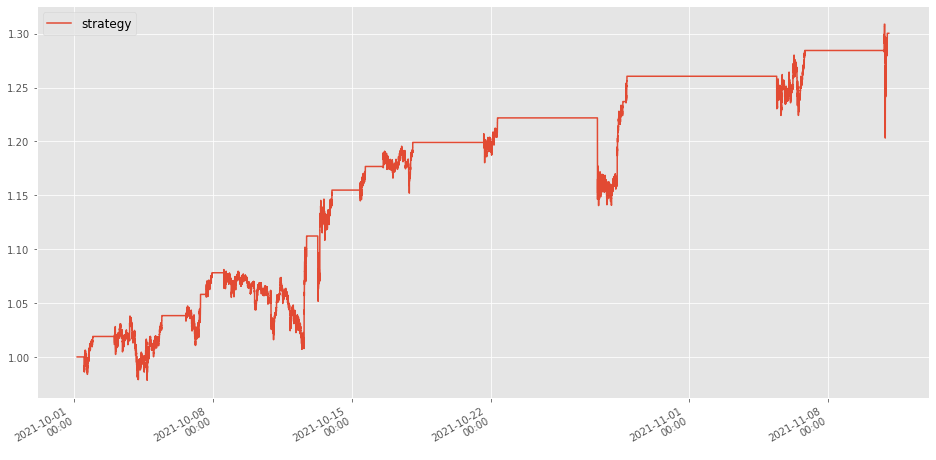

In [1]:
from hypecommons import download_history_fast, plot, plt, display_whole
from datetime import datetime, timedelta
from math import cos, sin, pi
import numpy as np
import pandas as pd
import json
import telegram

start_time = datetime(2021, 10, 1)
days_since_start = 1 + (datetime.now() - start_time).days

def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig, freq=1):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / freq
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
    return df


def soru_viga_ellipse(X, Y, decfun=False):
    A = .012
    B = .046
    x = X - .998
    y = Y - .995
    alpha = -pi/14
    F = (x * cos(alpha) + y * sin(alpha)) ** 2 / A ** 2 + (x * sin(alpha) - y * cos(alpha)) ** 2 / B ** 2 - 1
    return F if decfun else F >= 0

def simulate(df_sim, target=1.02, stop=0.94, hrs_frozen=0, fees=0.001):
    stake = [1]
    action = []
    invested = False
    frozen = False
    for i, row in df_sim.iterrows():
        if frozen and i >= last_loss + timedelta(hours=hrs_frozen):
            frozen = False
        if frozen and i < last_loss + timedelta(hours=hrs_frozen):
            stake.append(stake[-1])
            action.append('FROZEN')
        elif row['pred'] and not invested:
            stake.append(stake[-1] * (1-fees))
            invested = True
            take_profit = row['close'] * target
            stop_loss = row['close'] * stop
            action.append('BUY')
        elif invested:
            if row['high'] > take_profit:
                invested = False
                action.append('PROFIT')
                stake.append(stake[-1] / prev_close * take_profit)
            elif row['low'] < stop_loss:
                invested = False
                action.append('LOSS')
                stake.append(stake[-1] / prev_close * stop_loss)
                last_loss = i
                frozen = True
            else:
                stake.append(stake[-1] / prev_close * row['close'])
                action.append('----')
        else:
            stake.append(stake[-1])
            action.append('----')
        prev_close = row['close']
    df_sim['strategy'] = stake[1:]
    df_sim['action'] = action
    return df_sim

df = download_history_fast('BNBBUSD', start_time.strftime("%Y%m%d%H%M%S"), freq=1, days=days_since_start, cache=False)
print("Preparing data...")
df = normalise(df)
df.dropna(inplace=True)
df['pred'] = np.vectorize(soru_viga_ellipse)(df['close_ema26_norm'], df['close_ma200_norm'])
df = df.set_index(pd.to_datetime(df.index))
print("Simulating...")
df = simulate(df)
df['hold'] = df['close'] / df['close'].iloc[0]

print("Generating image...")
plot(plt.plot, df, ['strategy'], fig_size=(16, 8), show=False)
plt.savefig('assets.png')
print("Done.")

ticker = df['close'].iloc[-1]

assets = round(df['strategy'].iloc[-1], 2)
assets_perc = round((assets - 1) * 100, 1)

months_since_start = (df.index[-1] - start_time).total_seconds() / (3600*24*30)
apy = round(assets ** (12 / months_since_start), 2)
apy_perc = round((assets ** (12 / months_since_start) - 1) * 100, 0)

movements = df[df['action'].isin(['BUY', 'PROFIT', 'LOSS'])]
if len(movements) > 0:
    last_movement = movements.iloc[-1]
    open_pos = last_movement['action'] == 'BUY'
    if open_pos:
        open_pos_trend_perc = round((ticker - last_movement['close']) / last_movement['close'], 1)
    else:
        open_pos_trend_perc = None
else:
    open_pos = False
    open_pos_trend_perc = None

trader_info = {
    'timestamp': df.index[-1].tz_localize('Europe/London').strftime("%Y-%m-%d %H:%M:%S"),
    'ticker': ticker,
    'open_pos': open_pos,
    'open_pos_trend_perc': open_pos_trend_perc,
    'assets': assets,
    'assets_perc': assets_perc,
    'apy': apy,
    'apy_perc': apy_perc,
}

try:
    with open('trader_info.json') as f:
        old = json.load(f)
    old_open_pos = old['open_pos']
    print(f"Old open pos: {old_open_pos}")
except:
    old_open_pos = False
    print("Old open pos assumed false.")

bot = telegram.Bot(token='2010682261:AAHUIPi57YnTyUt5mZr9q2ohUTCg7K4Rd1w')

if open_pos and not old_open_pos:
    bot.send_message(-1001734966233, "Position opened!")

if not open_pos and old_open_pos:
    bot.send_message(-1001734966233, f"Position closed! APY: {apy_perc}%")

with open('trader_info.json', 'w') as f_out:
    json.dump(trader_info, f_out)